# Analysis of Russell Ranch Century Experiment

In this notebook I analyze data from the Russell Ranch Century Experiment to understand how use of irrigation, fertilizer, and compost impact crop yields.

This data is publicly available at https://asi.ucdavis.edu/programs/rr/research/data and is cited as:

Russell Ranch Sustainable Agriculture Facility. 2020. Cover crop biomass yields. Davis, CA: Russell Ranch Electronic Data Archives: CC-001. [Database]. https://asi.ucdavis.edu/programs/rr/research/data

The meta data file is available at: https://asi.ucdavis.edu/sites/g/files/dgvnsk5751/files/inline-files/CenturyExperiment_metadata.pdf.

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Import data files

Four data files are available for download from the above website. These files include information on:

1. CROPS: plots, crops grown, and irrigation type used
2. IRR: irrigation amounts applied
- HARVEST: harvest measurements
- NUT_COMP: fertilizer and compost nutrient composition
- NUT_AMT: fertilizer and compost application amounts


In [404]:
# import data files
crops = pd.read_csv("/Users/emma/Documents/Data_Science/climate_agriculture/Russell_Ranch/Sheet 1.csv")
irr = pd.read_csv("/Users/emma/Documents/Data_Science/climate_agriculture/Russell_Ranch/File 2.csv")
harvest = pd.read_csv("/Users/emma/Documents/Data_Science/climate_agriculture/Russell_Ranch/File 3.csv")
nut_comp = pd.read_csv("/Users/emma/Documents/Data_Science/climate_agriculture/Russell_Ranch/Sheet 4.csv")
nut_amt = pd.read_csv("/Users/emma/Documents/Data_Science/climate_agriculture/Russell_Ranch/Sheet 5.csv")

In [405]:
# check for data type
crops.dtypes
irr.dtypes
harvest.dtypes
nut_comp.dtypes
nut_amt.dtypes

experiment_name          object
plot_name                object
plot_side                object
date                     object
year                    float64
fertilizer_name          object
fertilizer_unit          object
fertilization_amount      int64
dtype: object

## Clean data frames

Date columns in irr, harvest, and nut_amt need to be converted to datetime data type.

In [406]:
irr.date = pd.to_datetime(irr.date)
harvest.date = pd.to_datetime(harvest.date)
nut_amt.date = pd.to_datetime(nut_amt.date)

Nut_amt does not have year specified. Determine year from date column.

In [407]:
nut_amt.year = nut_amt.date.dt.year

There are some empty date and year columns. Looking at the data, it's clear that the years 2014 and 2015 were not entered. Making a guess for the overall year date seems like a reasonable choice, but I will leave the date column empty because choosing an exact date is more unknown. The null values in date will serve as a reminder that I made up this data.

In [408]:
pd.set_option('display.max_rows', 200)
nut_amt[nut_amt.date.isnull()]   # find null values
nut_amt[(nut_amt.fertilizer_name =='2018_pm_compost')&(nut_amt.index>2369)]   # display values of interest
nut_amt.year[(nut_amt.index>2381)&(nut_amt.index<2394)]=2014.0   # set year to 2014
nut_amt.year[(nut_amt.index>2393)&(nut_amt.index<2406)]=2015.0   # set year to 2015

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


For ease of working with the plot_name data, let's create a plot_number variable as an integer in each of the dataframes it exists within.

In [409]:
crops['plot_number'] = crops.plot_name.astype('int')
harvest['plot_number'] = harvest.plot_name.astype('int')
irr['plot_number'] = irr.plot_name.astype('int')
nut_amt['plot_number'] = nut_amt.plot_name.astype('int')
crops.columns

Index(['experiment_name', 'plot_name', 'plot_side', 'block', 'year',
       'system_code', 'crop', 'irrigation_type', 'plot_number'],
      dtype='object')

## Explore the data by making some simple plots.


### Harvest Yields
I'll start with looking at harvest yields. How do yields of crops vary through time on each plot?


In [ ]:
# How do yields vary for each crop in each plot?

plot_names = crops.plot_name.unique()
for i in range(0,len(plot_names)):
    #print("i=",i)
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    crop_names = harvest[(harvest.plot_name==plot_names[i])].crop.unique()
    for j in range(0,len(crop_names)):
        #print("j=",j)
        plant_parts = harvest[(harvest.plot_name==plot_names[i])&(harvest.crop==crop_names[j])].plant_part.unique()
        for k in range(0,len(plant_parts)):
           # print("k=", k)
            harvest_temp = harvest[(harvest.plot_name==plot_names[i])&(harvest.crop==crop_names[j])&(harvest.plant_part==plant_parts[k])]
            ax.plot(harvest_temp.year, harvest_temp.measurement_amount,'x', label='{},{}'.format(crop_names[j],plant_parts[k]))
            ax.legend(loc='best')
            ax.set_title('Plot {}'.format(plot_names[i]), fontsize=24);
            ax.set_xlabel('Year', fontsize=24)
            ax.set_ylabel('Harvest Amount', fontsize=24)

Note that plot 7_1 appears to not have any data. Not sure for now what is going on with this.

There are no strong trends in these plots. Options:

1. Could try finding linear regressions for each. 
2. Could try plotting total yield, not separated by plant type -- do I need to convert to something like percentage increase to account for the fact that different crops have different absolute values of yields?


In [369]:
crop_names = harvest.crop.unique()
crop_names


array(['solanum_lycopersicum', 'winter_cover_plants', 'maize', 'wheat',
       'medicago_sativa'], dtype=object)

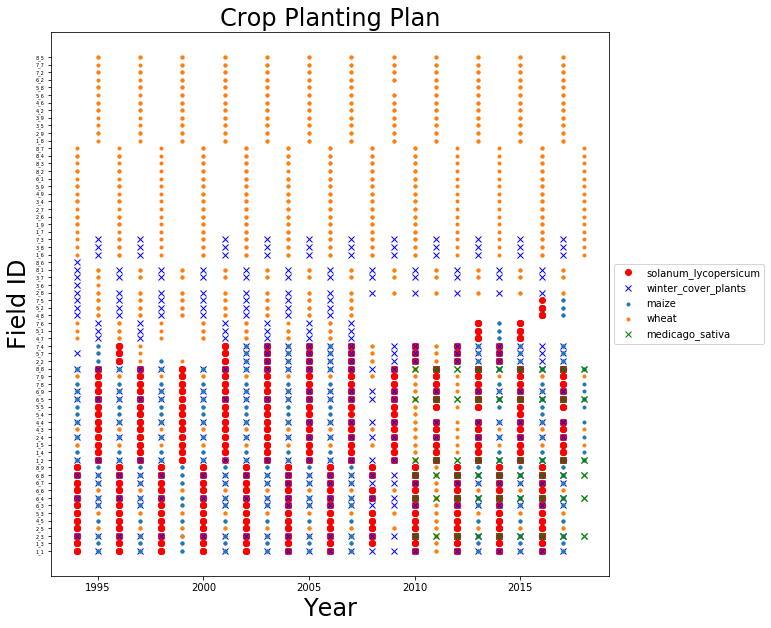

In [413]:
import re
solanum_lycopersicum = re.compile("solanum_lycopersicum$") # initiate regex for searching within for loop
winter_cover_plants = re.compile("winter_cover_plants$")
maize = re.compile("maize$")
wheat = re.compile("wheat$")

crop_names = harvest.crop.unique()
fig, ax = plt.subplots(1,1, figsize=(10,10))
for i in range(0,len(crop_names)):
    crop_year=harvest[harvest.crop==crop_names[i]].year
    crop_field = harvest[harvest.crop==crop_names[i]].plot_name
    if solanum_lycopersicum.search(crop_names[i]):
        ax.plot(crop_year,crop_field,'ro',label='{}'.format(crop_names[i]))
    elif winter_cover_plants.search(crop_names[i]):
        ax.plot(crop_year,crop_field,'bx',label='{}'.format(crop_names[i]))
    elif maize.search(crop_names[i]) or wheat.search(crop_names[i]):
        ax.plot(crop_year,crop_field,'.',label='{}'.format(crop_names[i]))
    else:
        ax.plot(fert_year,fert_field,'gx',label='{}'.format(crop_names[i]))
    #ax.legend(loc='best')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('Crop Planting Plan', fontsize=24);
    ax.set_xlabel('Year', fontsize=24)
    ax.set_ylabel('Field ID', fontsize=24)
    ax.tick_params(axis='y',labelsize=5)

This figure is useful in visualizing the crop planting plan on a broad scale. About half of fields are just being used for wheat, either with or without cover crops. For those with cover crops, fields alternate as to which year supports which crop, perhaps to account for interannual variability in weather.

The other half of the fields grow the full variety of crops, alternating tomatoes with either maize or wheat. Some of these fields incorporate cover crops either every year or in some years. Alfalfa is introduced in some fields in 2010. 

**Questions:**
1. How does complexity of crop rotation affect yield?
2. How does incorporation of cover crops affect yield?

Wheat is the common factor among all fields. How does wheat yield vary based on these factors? And what about fertilizer use?...

### Fertlizer Use

When and where was each fertilizer used? Create a plot showing what fertilizers were used in what fields in each year.

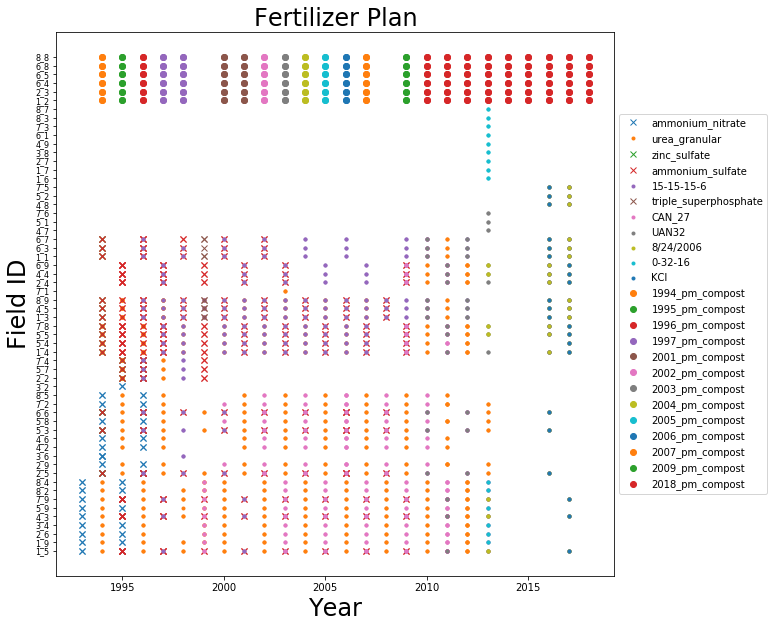

In [414]:
import re
compost = re.compile("compost$") # initiate regex for searching within for loop
ate = re.compile("ate$")

fertilizer_names = nut_amt.fertilizer_name.unique()
fig, ax = plt.subplots(1,1, figsize=(10,10))
for i in range(0,len(fertilizer_names)):
    fert_year=nut_amt[nut_amt.fertilizer_name==fertilizer_names[i]].year
    fert_field = nut_amt[nut_amt.fertilizer_name==fertilizer_names[i]].plot_name
    if compost.search(fertilizer_names[i]):
        ax.plot(fert_year,fert_field,'o',label='{}'.format(fertilizer_names[i]))
    elif ate.search(fertilizer_names[i]):
        ax.plot(fert_year,fert_field,'x',label='{}'.format(fertilizer_names[i]))
    else:
        ax.plot(fert_year,fert_field,'.',label='{}'.format(fertilizer_names[i]))
    #ax.legend(loc='best')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('Fertilizer Plan', fontsize=24);
    ax.set_xlabel('Year', fontsize=24)
    ax.set_ylabel('Field ID', fontsize=24)
    ax.tick_params(axis='y',labelsize=8)
    #plt.yticks([]) # hide field IDs on axis because they are so small and don't really matter

There is a lot going on in the above plot, but the overall pattern of colors and shapes gives a sense of the fertilizer strategy. Six fields at the top of plot received compost as fertilizer. The compost varied by year based on what was available. In some years, some fields received no fertilizer and others received multiple kinds. 

This is useful, like the Crop Planting figure above, in visualizing the experiments. However, the y-axes do not match between the two figures. Plotting numerically by plot_number rather than plot_name is problematic because it erases the patterns that pop out in each figure. To combine information from the two plans, I will need different strategies.

Ideas:
1. Focus on just the fields using compost and see how how nutrient value of compost correlates with crop yield
2. Aggregate yield data on fields with same/similar fertilizer protocol and compare among protocols
3. Can I make similar plot to visualize the crop plan?

### Impact of fertilizer

Next I'll take a look at the relationship between nutrient inputs and crop yields. How does the crop yield in each plot in each year compare to the nutrient input?

Let's start with the amount total carbon applied to each field. The nut_comp dataframe contains information about the percentage of total carbon in the compost mixture from each year.

In [282]:
nut_name = nut_amt.fertilizer_name
nut_compost = nut_name.str.findall('compost$')
nut_compost.head(50)

#nut_amt[nut_amt.fertilizer_name.str.findall('*compost')]
nut_amt.fertilizer_name.unique()

array(['ammonium_nitrate', 'urea_granular', 'zinc_sulfate',
       'ammonium_sulfate', '15-15-15-6', 'triple_superphosphate',
       'CAN_27', 'UAN32', '8/24/2006', '0-32-16', 'KCl',
       '1994_pm_compost', '1995_pm_compost', '1996_pm_compost',
       '1997_pm_compost', '2001_pm_compost', '2002_pm_compost',
       '2003_pm_compost', '2004_pm_compost', '2005_pm_compost',
       '2006_pm_compost', '2007_pm_compost', '2009_pm_compost',
       '2018_pm_compost'], dtype=object)

In [329]:
nut_amt[nut_amt.fertilizer_name=='KCl']

,experiment_name,plot_name,plot_side,date,year,fertilizer_name,fertilizer_unit,fertilization_amount
2040,century,1_1,COMPOSITE,2016-07-20,2016.0,KCl,kg/ha,90
2041,century,1_3,COMPOSITE,2016-07-20,2016.0,KCl,kg/ha,90
2042,century,2_5,COMPOSITE,2016-07-20,2016.0,KCl,kg/ha,90
2043,century,4_5,COMPOSITE,2016-07-20,2016.0,KCl,kg/ha,90
2044,century,4_8,COMPOSITE,2016-07-20,2016.0,KCl,kg/ha,90
2045,century,5_2,COMPOSITE,2016-07-20,2016.0,KCl,kg/ha,90
2046,century,5_3,COMPOSITE,2016-07-20,2016.0,KCl,kg/ha,90
2047,century,6_3,COMPOSITE,2016-07-20,2016.0,KCl,kg/ha,90
2048,century,6_6,COMPOSITE,2016-07-20,2016.0,KCl,kg/ha,90
2049,century,6_7,COMPOSITE,2016-07-20,2016.0,KCl,kg/ha,90


In [303]:
nut_year_plot = [nut_amt[nut_amt.fertilizer_name=='2001_pm_compost'].year, nut_amt[nut_amt.fertilizer_name=='2001_pm_compost'].plot_name]
nut_year_plot

[2226    2000.0
 2227    2000.0
 2228    2000.0
 2229    2000.0
 2230    2000.0
 2231    2000.0
 2232    2000.0
 2233    2000.0
 2234    2000.0
 2235    2000.0
 2236    2000.0
 2237    2000.0
 2238    2001.0
 2239    2001.0
 2240    2001.0
 2241    2001.0
 2242    2001.0
 2243    2001.0
 2244    2001.0
 2245    2001.0
 2246    2001.0
 2247    2001.0
 2248    2001.0
 2249    2001.0
 Name: year, dtype: float64, 2226    1_2
 2227    1_2
 2228    2_3
 2229    2_3
 2230    6_4
 2231    6_4
 2232    6_5
 2233    6_5
 2234    6_8
 2235    6_8
 2236    8_8
 2237    8_8
 2238    1_2
 2239    1_2
 2240    2_3
 2241    2_3
 2242    6_4
 2243    6_4
 2244    6_5
 2245    6_5
 2246    6_8
 2247    6_8
 2248    8_8
 2249    8_8
 Name: plot_name, dtype: object]

In [332]:
fert_field[0:-1:10]
fert_field

0      1_5
1      1_5
2      1_9
3      1_9
4      2_6
5      2_6
6      3_4
7      3_4
8      4_3
9      4_3
10     5_9
11     5_9
12     7_9
13     7_9
14     8_2
15     8_2
16     8_4
17     8_4
96     2_5
97     2_5
98     2_9
99     2_9
100    3_6
101    3_6
102    3_6
103    3_6
104    4_2
105    4_2
106    4_6
107    4_6
108    5_3
109    5_3
110    5_8
111    5_8
112    6_6
113    6_6
114    7_2
115    7_2
116    8_5
117    8_5
238    1_5
239    1_5
240    1_9
241    1_9
242    2_6
243    2_6
244    3_2
245    3_2
246    3_4
247    3_4
248    4_3
249    4_3
250    5_9
251    5_9
252    7_9
253    7_9
254    8_2
255    8_2
256    8_4
257    8_4
372    2_5
373    2_5
374    5_3
375    5_3
376    6_6
377    6_6
378    2_2
379    2_2
380    5_7
381    5_7
382    7_4
383    7_4
384    2_9
385    2_9
386    4_2
387    4_2
388    4_6
389    4_6
390    5_8
391    5_8
392    7_2
393    7_2
394    8_5
395    8_5
Name: plot_name, dtype: object